# <p style="font-family:newtimeroman; text-align:center; font-size:40px;">A Novel Data Extraction Framework Using Natural Language Processing (DEFNLP) Techniques</p>
<p style="font-family:newtimeroman; text-align:center; font-size:30px;">Discover how data is used for the public good</p>

<a id='0'></a>
# <p style="background-color:purple; font-family:newtimeroman; font-size:100%; text-align:center; border-radius: 15px 50px; color:white;">Please dont forget to upvote the notebook </p>

## In this notebook basically we have to predict text for some strings by using nlp techniques
*** 
>The objective of the competition is to identify the mention of datasets within scientific publications.

This competition challenges data scientists to show how publicly funded data are used to serve science and society. Evidence through data is critical if government is to address the many threats facing society, including; pandemics, climate change, Alzheimer’s disease, child hunger, increasing food production, maintaining biodiversity, and addressing many other challenges. Yet much of the information about data necessary to inform evidence and science is locked inside publications.

Can natural language processing find the hidden-in-plain-sight data citations? Can machine learning find the link between the words used in research articles and the data referenced in the article?

Now is the time for data scientists to help restore trust in data and evidence. In the United States, federal agencies are now mandated to show how their data are being used. The new Foundations of Evidence-based Policymaking Act requires agencies to modernize their data management. New Presidential Executive Orders are pushing government agencies to make evidence-based decisions based on the best available data and science. And the government is working to respond in an open and transparent way.

This competition will build just such an open and transparent approach. The results will show how public data are being used in science and help the government make wiser, more transparent public investments. It will help move researchers and governments from using ad-hoc methods to automated ways of finding out what datasets are being used to solve problems, what measures are being generated, and which researchers are the experts. Previous competitions have shown that it is possible to develop algorithms to automate the search and discovery of references to data. Now, we want the Kaggle community to develop the best approaches to identify critical datasets used in scientific publications.

In this competition, you'll use natural language processing (NLP) to automate the discovery of how scientific data are referenced in publications. Utilizing the full text of scientific publications from numerous research areas gathered from CHORUS publisher members and other sources, you'll identify data sets that the publications' authors used in their work.

It achieves this goal by working with the agencies to create value for the taxpayer from the careful use of data by building new technologies to enable secure access to and sharing of confidential microdata and by training agency staff to acquire modern data skills.

If successful, you'll help support evidence in government data. Automated NLP approaches will enable government agencies and researchers to quickly find the information they need. The approach will be used to develop data usage scorecards to better enable agencies to show how their data are used and bring down a critical barrier to the access and use of public data.

<a id='1'></a>
# <p style="background-color:blue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 10px 25px;color:white;">Table of Content</p>
* [1. Importing Modules & Libraries](#1)
* [2. Data Exploration](#2)
* [3. Data Vizualization](#3)
* [4. Data Cleaning](#4)
* [5. Baseline Model & Submission](#5)

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Importing Modules & Libraries</p>

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import re
import json
import time
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
import plotly.graph_objects as go

import nltk
import urllib.request
from PIL import Image
import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.max_length = 4000000
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

from tqdm.autonotebook import tqdm
import string

%matplotlib inline

os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data/')

['sample_submission.csv', 'train.csv', 'test', 'train']

We are provided with 4 main pieces of data:

* `train.csv:` The CSV file containing all the metadata of the publications, such as their title and the dataset they utilize.
* `train:` The directory containing the actual publications that are referenced in train.csvin JSON format.
* `test:` The directory containing the actual publications that will be used for testing purposes (thus, with no ground truth CSV file available).
* `sample_submission.csv:` The CSV file containing all the publications IDs in the test set, for which we'll have to populate the prediction column.

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Data Exploration</p>

# Reading csv files and train & test file paths

In [2]:
train_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')
sample_sub = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
test_files_path = '../input/coleridgeinitiative-show-us-the-data/test'

<a id='1'></a>
## <p style="text-align:center;">Data Description</p>
train.csv - labels and metadata for the training set train/test directory - the full text of the training/test set's publications in JSON format, broken into sections with section titles

* `id` - publication id - note that there are multiple rows for some training documents, indicating multiple mentioned datasets.
* `pub_title` - title of the publication (a small number of publications have the same title).
* `dataset_title` - the title of the dataset that is mentioned within the publication.
* `dataset_label` - a portion of the text that indicates the dataset.
* `cleaned_label` - the dataset_label, as passed through the clean_text function from the Evaluation page.

sample_submission.csv - a sample submission file in the correct format.
* `Id` - publication id.
* `PredictionString` - To be filled with equivalent of cleaned_label of train data.

In [3]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


<p style="color:blue;font-size:20px;">📝Great! we don't have any null values.</p>

### Observations

- 1) There are duplicate id's meaning that there are some pulications that are using mutiple datasets. That's why that id is repeating.
- 2) Same is the case with pub_title. A single publication is using mutiple datasets.
- 3) There is NO one to one mapping of id and pub_title. Meaning that there are cases when two different publications (from two different authors) have same title. Well, interesting!!!
- 4) There 45 dataset titles but 130 dataet labels. Meaning that there are some datasets that has multiple labels. We'll look into how these two are related.

<p style="color: blue;font-size:15px;">📝 We have duplicate ids but we are not going to remove them from data because one research paper may consist of more than one datasets. Anyhow duplicate ids with respective datasets are shown below</p>

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Data Vizualization</p>

<p style="color:blue;font-size:25px;">📝Merge all text from json into train.csv with colmn name text</p>

In [4]:
def read_append_return(filename, train_files_path=train_files_path, output='text'):
    """
    Function to read json file and then return the text data from them and append to the dataframe
    """
    json_path = os.path.join(train_files_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

<p style="color:blue;font-size:20px;">📝tqdm is used to show any code running with a progress bar</p>

In [5]:
%%time
tqdm.pandas()   
train_df['text'] = train_df['Id'].progress_apply(read_append_return)

  0%|          | 0/19661 [00:00<?, ?it/s]

CPU times: user 14.7 s, sys: 6.61 s, total: 21.3 s
Wall time: 2min 3s


<p style="color:blue;font-size:20px;">📝We have our text appended in our train dataframe</p>

In [6]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,", stress satisfactory outcomes for all youth,..."
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Federal Reserve Bank of Richmond S1. Accountin...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This article investigates an important factor ...


In [7]:
%%time
tqdm.pandas()
sample_sub['text'] = sample_sub['Id'].progress_apply(partial(read_append_return, train_files_path=test_files_path))

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 49.9 ms, sys: 2.47 ms, total: 52.4 ms
Wall time: 85.7 ms


<p style="color:blue;font-size:20px;">📝Also, we have the text of for the sample_submission file</p>

In [8]:
sample_sub.head()

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,NaN,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN,"Cape Hatteras National Seashore (CAHA), locate..."
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN,A significant body of research has been conduc...


In [9]:
sample_sub['text']

0    Cognitive deficits and reduced educational ach...
1    This report describes how the education system...
2    Cape Hatteras National Seashore (CAHA), locate...
3    A significant body of research has been conduc...
Name: text, dtype: object

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Data Cleaning</p>

In [10]:
def text_cleaning(text):
    '''
    Converts all text to lower case, Removes special charecters, emojis and multiple spaces
    text - Sentence that needs to be cleaned
    '''
    text = ''.join([k for k in text if k not in string.punctuation])
    text = re.sub('r[^\w\s]', ' ', str(text).lower()).strip()
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    text = lem.lemmatize(text)
#     text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
#     text = re.sub("/'+/g", ' ', text)
    
    return text

In [11]:
%%time
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(text_cleaning)

  0%|          | 0/19661 [00:00<?, ?it/s]

CPU times: user 3min 32s, sys: 2.95 s, total: 3min 35s
Wall time: 3min 35s


<p style="color:blue;font-size:20px;">📝We have our data cleaned!</p>

In [12]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this study used data from the national educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,stress satisfactory outcomes for all youth inc...
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,federal reserve bank of richmond s1 accounting...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this article investigates an important factor ...


In [13]:
text = train_df['text']
print(text)

0        this study used data from the national educati...
1        dropping out of high school is not necessarily...
2        stress satisfactory outcomes for all youth inc...
3        federal reserve bank of richmond s1 accounting...
4        this article investigates an important factor ...
                               ...                        
19656    our lives have been fundamentally altered this...
19657    the outbreak of the coronavirus disease 2019  ...
19658    the ongoing covid19 pandemic has challenged th...
19659    deployment of approximative mathematical model...
19660    deployment of approximative mathematical model...
Name: text, Length: 19661, dtype: object


<p style="color:blue;font-size:20px;">📝Remove stop words from <b>cleaned_label</b> of train.csv</p>

In [14]:
words =list(train_df['cleaned_label'].values)
stopwords=['ourselves', 'hers','the','of','and','in', 'between', 'yourself', 'but', 'again','of', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
split_words=[]
for word in words:
    lo_w=[]
    list_of_words=str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist

*Command to do a regex substitution*

In [15]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Baseline model and Submission</p>

In [16]:
temp_1 = [x.lower() for x in train_df['dataset_label'].unique()]
temp_2 = [x.lower() for x in train_df['dataset_title'].unique()]
temp_3 = [x.lower() for x in train_df['cleaned_label'].unique()]

existing_labels = set(temp_1 + temp_2 + temp_3)
id_list = []
lables_list = []
for index, row in tqdm(sample_sub.iterrows()):
    sample_text = row['text']
    row_id = row['Id']
    temp_df = train_df[train_df['text'] == text_cleaning(sample_text)]
    cleaned_labels = temp_df['cleaned_label'].to_list()
    for known_label in existing_labels:
        if known_label in sample_text.lower():
            cleaned_labels.append(clean_text(known_label))
    cleaned_labels = [clean_text(x) for x in cleaned_labels]
    cleaned_labels = set(cleaned_labels)
    lables_list.append('|'.join(cleaned_labels))
    id_list.append(row_id)

0it [00:00, ?it/s]

In [17]:
submission1 = pd.DataFrame()
submission1['Id'] = id_list
submission1['PredictionString'] = lables_list

In [18]:
submission1.head()

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,adni|alzheimer s disease neuroimaging initiati...
1,2f392438-e215-4169-bebf-21ac4ff253e1,common core of data|trends in international ma...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,noaa storm surge inundation|sea lake and overl...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes


In [19]:
from spacy import displacy
from collections import Counter
import en_core_web_lg
nlp = en_core_web_lg.load()

In [20]:
sample_sub2 = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')

In [21]:
%%time
tqdm.pandas()
sample_sub2['text'] = sample_sub2['Id'].progress_apply(partial(read_append_return, train_files_path=test_files_path))

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 48.7 ms, sys: 2.94 ms, total: 51.6 ms
Wall time: 52.6 ms


In [22]:
sample_sub2['text'] = sample_sub2['text'].str.replace('[^\w\s]','')
sample_sub2.head()

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,NaN,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN,Cape Hatteras National Seashore CAHA located a...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN,A significant body of research has been conduc...


In [23]:
#del train_df
# del sample_sub

In [24]:
sample_sub2.head()

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,NaN,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN,Cape Hatteras National Seashore CAHA located a...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN,A significant body of research has been conduc...


In [25]:
import gc
gc.collect()

134

In [26]:
datalist = pd.read_csv('../input/para-data/datalist.csv')

In [27]:
datalist.head()

,Data
0,HBCS
1,CHS
2,NCNG
3,ADNI
4,OECD


In [28]:
datasetLabels= datalist['Data']
print(datasetLabels)

0                                                  HBCS
1                                                   CHS
2                                                  NCNG
3                                                  ADNI
4                                                  OECD
5                                                  PISA
6                                                   CPS
7                                                   CCD
8                                                 IPEDS
9                                                   NPS
10                                               SLRRMS
11                                                  IRI
12                                                  CNP
13                                                  CES
14                                                  FMI
15                     Helsinki Birth Cohort Study HBCS
16                      Cardiovascular Health Study CHS
17               Norwegian Cognitive NeuroGeneti

In [29]:
a = [(x,i) for x, y in zip(sample_sub2['Id'],sample_sub2['text']) for i in datasetLabels if i in y]
print (a)

[('2100032a-7c33-4bff-97ef-690822c43466', 'HBCS'), ('2100032a-7c33-4bff-97ef-690822c43466', 'CHS'), ('2100032a-7c33-4bff-97ef-690822c43466', 'NCNG'), ('2100032a-7c33-4bff-97ef-690822c43466', 'ADNI'), ('2100032a-7c33-4bff-97ef-690822c43466', 'Helsinki Birth Cohort Study HBCS'), ('2100032a-7c33-4bff-97ef-690822c43466', 'Cardiovascular Health Study CHS'), ('2100032a-7c33-4bff-97ef-690822c43466', 'Norwegian Cognitive NeuroGenetics NCNG'), ('2100032a-7c33-4bff-97ef-690822c43466', 'Alzheimers Disease Neuroimaging Initiative ADNI'), ('2f392438-e215-4169-bebf-21ac4ff253e1', 'OECD'), ('2f392438-e215-4169-bebf-21ac4ff253e1', 'PISA'), ('2f392438-e215-4169-bebf-21ac4ff253e1', 'CPS'), ('2f392438-e215-4169-bebf-21ac4ff253e1', 'CCD'), ('2f392438-e215-4169-bebf-21ac4ff253e1', 'IPEDS'), ('2f392438-e215-4169-bebf-21ac4ff253e1', 'CES'), ('2f392438-e215-4169-bebf-21ac4ff253e1', 'Organization for Economic Cooperation and Development OECD'), ('2f392438-e215-4169-bebf-21ac4ff253e1', 'Program for Internationa

In [30]:
sample_sub2 = pd.DataFrame(a, columns=['Id', 'PredictionString'])
sample_sub2 = sample_sub2.groupby('Id').agg({'PredictionString': '|'.join}).reset_index()
sample_sub2.head()

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,HBCS|CHS|NCNG|ADNI|Helsinki Birth Cohort Study...
1,2f392438-e215-4169-bebf-21ac4ff253e1,OECD|PISA|CPS|CCD|IPEDS|CES|Organization for E...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NPS|SLRRMS|National Park Service NPS|Sea Level...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,IRI|CNP|CES|FMI|Information Resource Incorpora...


In [31]:
sample_sub2['PredictionString'] = [x.lower() for x in sample_sub2['PredictionString'].unique()]

In [32]:
#my_list = ["cohort study [lbc1936; n","lothian birth cohort study [lbc1936","Information Resource Incorporated (IRI","on@3", "two#", "thre%e"]
removetable = str.maketrans('', '', ',@#%([')
sample_sub2['PredictionString'] = [s.translate(removetable) for s in sample_sub2['PredictionString']]
print(sample_sub2['PredictionString'])

0    hbcs|chs|ncng|adni|helsinki birth cohort study...
1    oecd|pisa|cps|ccd|ipeds|ces|organization for e...
2    nps|slrrms|national park service nps|sea level...
3    iri|cnp|ces|fmi|information resource incorpora...
Name: PredictionString, dtype: object


In [33]:
# stop_words = ["the "
#              ]

# pat = '|'.join(r"\b{}\b".format(x) for x in stop_words)
# sample_sub2['PredictionString'] = sample_sub2['PredictionString'].str.replace(pat, '')


# #top_words = set(stop_words)
# #f = lambda x: ' '.join(w for w in x.split() if not w in stop_words)
# #newdata['Verbatim2'] = newdata['Verbatim'].apply(f)

# print (sample_sub2['PredictionString'])

In [34]:
submission2 = pd.DataFrame()
submission2['Id'] = sample_sub2['Id']
submission2['PredictionString'] = sample_sub2['PredictionString']
submission2.head()

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,hbcs|chs|ncng|adni|helsinki birth cohort study...
1,2f392438-e215-4169-bebf-21ac4ff253e1,oecd|pisa|cps|ccd|ipeds|ces|organization for e...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,nps|slrrms|national park service nps|sea level...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,iri|cnp|ces|fmi|information resource incorpora...


# govt dataset

In [35]:
def read_json_pub(filename, train_files_path=train_files_path, output='text'):
    json_path = os.path.join(train_files_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [36]:
def text_cleaning2(text):
    '''
    Converts all text to lower case, Removes special charecters, emojis and multiple spaces
    text - Sentence that needs to be cleaned
    '''
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    text = re.sub(' +', ' ', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [37]:
def clean_text2(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

In [38]:
# random sample for testing
train_sample=train_df.sample(n = 10)

train_sample

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
10343,bf7e2895-37e8-48bc-9edd-b30a6e6ae772,A Local-to-Global Metric Learning Framework Fr...,Alzheimer's Disease Neuroimaging Initiative (A...,Alzheimer's Disease Neuroimaging Initiative (A...,alzheimer s disease neuroimaging initiative adni,metric plays a key role in the description of ...
10811,3ba42bd7-4106-4470-b606-385f12b7566d,A data-driven model of biomarker changes in sp...,Alzheimer's Disease Neuroimaging Initiative (A...,Alzheimer's Disease Neuroimaging Initiative (A...,alzheimer s disease neuroimaging initiative adni,we demonstrate the use of a probabilistic gene...
6751,2083d879-cb77-4bfb-b6d9-cbb4c10650df,"Effect of age, ethnicity, sex, cognitive statu...",Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,please cite this article as r duara da loewens...
16486,2f431a1e-9b58-4949-a0c2-73891b90d610,Rural Broadband At A Glance,Agricultural Resource Management Survey,Agricultural Resource Management Survey,agricultural resource management survey,he size and growth of us internet use is impre...
10496,542d80f2-190f-484b-96ff-1e4f3e16d04c,The disengaging brain: Dynamic transitions fro...,Alzheimer's Disease Neuroimaging Initiative (A...,Alzheimer's Disease Neuroimaging Initiative (A...,alzheimer s disease neuroimaging initiative adni,human functional brain connectivity is usually...
12746,e96ee723-9d72-462e-bb6e-2f2332ae47b3,Short-Term Enrollment in Postsecondary Educati...,Beginning Postsecondary Student,Beginning Postsecondary Students Longitudinal ...,beginning postsecondary students longitudinal ...,in this report attrition departure and leaving...
2692,031e4b40-7c35-4607-b760-6d3fcac9b493,A Geometry-Driven Optical Flow Warping for Spa...,Baltimore Longitudinal Study of Aging (BLSA),Baltimore Longitudinal Study of Aging,baltimore longitudinal study of aging,abstractspatial normalization is frequently us...
9704,b6d22ba8-2d1b-4810-b5f8-2830c5945047,Joint Coupled-Feature Representation and Coupl...,Alzheimer's Disease Neuroimaging Initiative (A...,Alzheimer's Disease Neuroimaging Initiative (A...,alzheimer s disease neuroimaging initiative adni,alzheimers disease ad and its early stage mild...
15267,3330f147-d604-4abf-ad4e-107c0f917d72,Economics of Gendered Distribution of Resourc...,Trends in International Mathematics and Scienc...,Trends in International Mathematics and Scienc...,trends in international mathematics and scienc...,twentyfive years ago congress passed the scien...
6534,ef30710a-65b0-4b1e-92ce-3dedd293479d,The age-related effect on cognitive performanc...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,background as research in treatments for neuro...


In [39]:
govt_df = pd.read_csv('../input/govtdataset/data_set_800.csv')

In [40]:
govt_df.head()

,title
0,adni
1,cccsl
2,ibtracs
3,noaa c cap
4,noaa c-cap


In [41]:
start_time = time.time()


#### remove >.5 jaccard matches from predicitons
def jaccard_similarity(s1, s2):
    l1 = s1.split(" ")
    l2 = s2.split(" ")    
    intersection = len(list(set(l1).intersection(l2)))
    union = (len(l1) + len(l2)) - intersection
    return float(intersection) / union

#############################
#path=train_data_path
path=test_files_path

#for training use train_sample

#for submission use sample_sub

#############

column_names = ["Id", "PredictionString"]

submission3 = pd.DataFrame(columns = column_names)

to_append=[]
for index, row in sample_sub.iterrows():
    to_append=[row['Id'],'']
    large_string = str(read_append_return(row['Id'],path))
    clean_string=text_cleaning2(large_string)
    for index, row2 in govt_df.iterrows():
        query_string = str(row2['title'])
        if query_string in clean_string:
            if to_append[1]!='' and clean_text2(query_string) not in to_append[1]:
                to_append[1]=to_append[1]+'|'+clean_text(query_string)
            if to_append[1]=='':
                to_append[1]=clean_text2(query_string)
     
    ###### remove similar jaccard
    #got_label=to_append[1].split('|')
    #filtered=[]
    #filtered_labels = ''
    #for label in sorted(got_label, key=len):
        #label = clean_text(label)
        #if len(filtered) == 0 or all(jaccard_similarity(label, got_label) < 1.0 for got_label in filtered):
            #filtered.append(label)
            #if filtered_labels!='':
                #filtered_labels=filtered_labels+'|'+label
            #if filtered_labels=='':
                #filtered_labels=label
    #to_append[1] = filtered_labels         
    #print ('################')
    #print (to_append)
    #print (large_string)
    #print ('################')
    ###### remove similar jaccard
    govt_df_length = len(submission3)
    submission3.loc[govt_df_length] = to_append
# submission3.to_csv('submission3.csv', index = False)
print("--- %s seconds ---" % (time.time() - start_time))
submission3

--- 1.6154224872589111 seconds ---


,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,adni|alzheimer s disease neuroimaging initiati...
1,2f392438-e215-4169-bebf-21ac4ff253e1,common core of data|nces common core of data|t...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,slosh model|noaa storm surge inundation|sea la...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes


In [42]:
# submission3 = pd.DataFrame()
# submission3['Id'] = govt_data['Id']
# submission3['PredictionString'] = govt_data['PredictionString']
# submission3.head()

<p style="color:blue;font-size:20px;">📝Merging DataTables into one Submission File</p>

In [43]:
##submission = pd.DataFrame(data= {'Id' : sample_sub['Id'], 'PredictionString' : ['','','','']})

In [44]:
##submission.head()

In [45]:
merged = pd.concat([submission1, submission2,submission3], sort=True).drop_duplicates()
submission = merged.dropna().groupby(['Id'], as_index=False).agg({'PredictionString' : '|'.join}).reset_index(drop=True)
print(submission)

                                     Id  \
0  2100032a-7c33-4bff-97ef-690822c43466   
1  2f392438-e215-4169-bebf-21ac4ff253e1   
2  3f316b38-1a24-45a9-8d8c-4e05a42257c6   
3  8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60   

                                    PredictionString  
0  adni|alzheimer s disease neuroimaging initiati...  
1  common core of data|trends in international ma...  
2  noaa storm surge inundation|sea lake and overl...  
3  rural urban continuum codes|iri|cnp|ces|fmi|in...  


In [46]:
(pd.concat(submission.melt(id_vars='Id').dropna() for df in [submission1,submission2])
    .groupby(['Id','variable'])['value'].apply(lambda x: '|'.join(x.unique()))
    .unstack()
)

variable,PredictionString
Id,
2100032a-7c33-4bff-97ef-690822c43466,adni|alzheimer s disease neuroimaging initiati...
2f392438-e215-4169-bebf-21ac4ff253e1,common core of data|trends in international ma...
3f316b38-1a24-45a9-8d8c-4e05a42257c6,noaa storm surge inundation|sea lake and overl...
8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes|iri|cnp|ces|fmi|in...


# remove Duplicates from dataframe

In [47]:
def remove_dup(strng):
    '''
     Input a string and split them 
    '''
    return '|'.join(list(dict.fromkeys(strng.split('|'))))

In [48]:
# my_dict = {'Tags':["Museum, Art Museum, Shopping, Museum",'Drink, Drink','Shop','Visit'],'Country':['USA','USA','USA', 'USA']}
# df = pd.DataFrame(my_dict)
submission['PredictionString'] = submission['PredictionString'].apply(lambda x: remove_dup(x))
submission

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,adni|alzheimer s disease neuroimaging initiati...
1,2f392438-e215-4169-bebf-21ac4ff253e1,common core of data|trends in international ma...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,noaa storm surge inundation|sea lake and overl...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes|iri|cnp|ces|fmi|in...


# **Sorting in a alphabetical Order**

In [49]:
submission['PredictionString'] = submission['PredictionString'].apply(lambda x: '|'.join(sorted(x.split('|'))))
print(submission)

                                     Id  \
0  2100032a-7c33-4bff-97ef-690822c43466   
1  2f392438-e215-4169-bebf-21ac4ff253e1   
2  3f316b38-1a24-45a9-8d8c-4e05a42257c6   
3  8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60   

                                    PredictionString  
0  adni|alzheimer s disease neuroimaging initiati...  
1  ccd|ces|common core of data|common core of dat...  
2  national oceanic atmospheric administration no...  
3  ces|cnp|consumer expenditure survey ces|consum...  


In [50]:
submission['PredictionString'][1]

'ccd|ces|common core of data|common core of data ccd|cps|current population survey cps|integrated postsecondary education data system|integrated postsecondary education data system ipeds|ipeds|nces common core of data|oecd|oecd national accounts database oecd|organization for economic cooperation and development oecd|pisa|ppp|program for international student assessment pisa|progress in international reading literacy study|schools and staffing survey|timss|trends in international mathematics and science study|trends in international mathematics and science study timss'

In [51]:
submission.head()

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,adni|alzheimer s disease neuroimaging initiati...
1,2f392438-e215-4169-bebf-21ac4ff253e1,ccd|ces|common core of data|common core of dat...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,national oceanic atmospheric administration no...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,ces|cnp|consumer expenditure survey ces|consum...


In [52]:
submission.to_csv('submission.csv', index=False)

In [53]:
#test = pd.concat([train_df,train_df],axis=0,ignore_index=True)

# PredictionString Analysis

#  Baseline Modelling 

In [54]:
submission1['PredictionString'][0]

'adni|alzheimer s disease neuroimaging initiative adni'

# Fine Tunning Through Huggingface Models

In [55]:
submission2['PredictionString'][0]

'hbcs|chs|ncng|adni|helsinki birth cohort study hbcs|cardiovascular health study chs|norwegian cognitive neurogenetics ncng|alzheimers disease neuroimaging initiative adni'

# Govt Datasets

In [56]:
submission3['PredictionString'][0]

'adni|alzheimer s disease neuroimaging initiative adni|pubmed'

# PredictionString after Merging dataframes

In [57]:
submission['PredictionString'][0]

'adni|alzheimer s disease neuroimaging initiative adni|alzheimers disease neuroimaging initiative adni|cardiovascular health study chs|chs|hbcs|helsinki birth cohort study hbcs|ncng|norwegian cognitive neurogenetics ncng|pubmed'

In [58]:
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from scipy.stats import multivariate_normal as mvn
import nltk
import os
import random

plt.style.use('fivethirtyeight')


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
data = submission['PredictionString']


tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [60]:
class Kmeans:
    """ K Means Clustering
    
    Parameters
    -----------
        k: int , number of clusters
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithm, default: 200
        
    Attributes
    -----------
       centroids: array, k, number_features
       
       cluster_labels: label for each data point
       
    """
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
            
    
    def initialise_centroids(self, data):
        """Randomly Initialise Centroids
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        centroids: array of k centroids chosen as random data points 
        """
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]

        return self.centroids
    
    
    def assign_clusters(self, data):
        """Compute distance of data from clusters and assign data point
           to closest cluster.
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
            
        """
        
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return  self.cluster_labels
    
    
    def update_centroids(self, data):
        """Computes average of all data points in cluster and
           assigns new centroids as average of data points
        
        Parameters
        -----------
        data: array or matrix, number_rows, number_features
        
        Returns
        -----------
        centroids: array, k, number_features
        """
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        
        return self.centroids
    
    
    def convergence_calculation(self):
        """
        Calculates 
        
        """
        pass
    
    def predict(self, data):
        """Predict which cluster data point belongs to
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
        """
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        """
        This function contains the main loop to fit the algorithm
        Implements initialise centroids and update_centroids
        according to max_iter
        -----------------------
        
        Returns
        -------
        instance of kmeans class
            
        """
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self    

array([-3.58040006,  7.08578225])

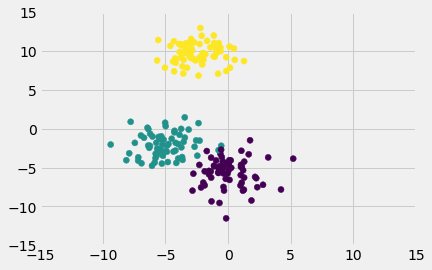

In [61]:
from sklearn.datasets import make_blobs
# create blobs
data = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=1.6, random_state=50)
# create np array for data points
points = data[0]
# create scatter plot
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')
plt.xlim(-15,15)
plt.ylim(-15,15)

X = data[0]
X[2]

In [62]:
temp_k  = Kmeans(4, 1, 600)
temp_fitted  = temp_k.fit_kmeans(X)
new_data = np.array([[1.066, -8.66],
                    [1.87876, -6.516],
                    [-1.59728965,  8.45369045],
                    [1.87876, -6.516]])
temp_fitted.predict(new_data)

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


array([0, 0, 1, 0])

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running
CPU times: user 149 ms, sys: 2.92 ms, total: 152 ms
Wall time: 151 ms


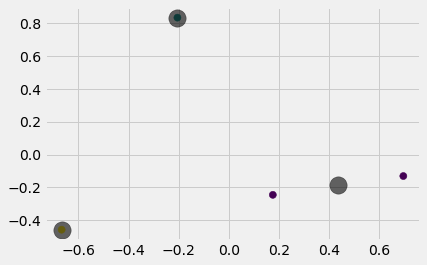

In [63]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(3, 1, 600)
%time fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

# SK learn Implementation

CPU times: user 18.8 ms, sys: 1.41 ms, total: 20.2 ms
Wall time: 29.4 ms


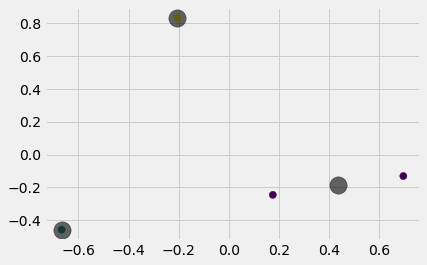

In [64]:
from sklearn.cluster import KMeans
n_clusters = 3
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= n_clusters, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

# Optimal Clusters

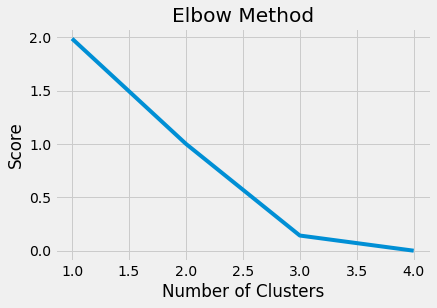

In [65]:
number_clusters = range(1, 5)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

# Extracting top features

In [66]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 20)

<AxesSubplot:xlabel='score', ylabel='features'>

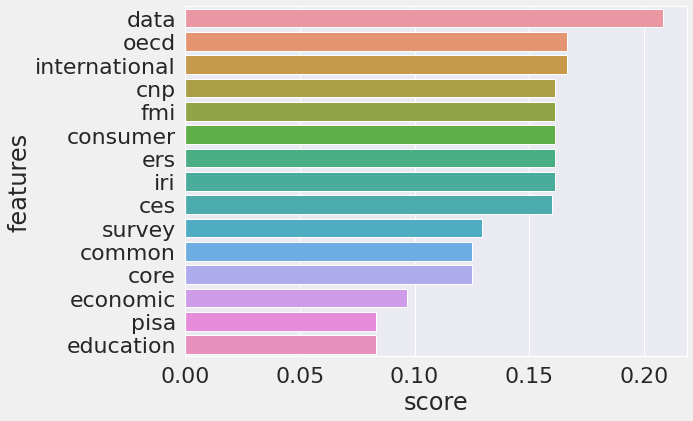

In [67]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

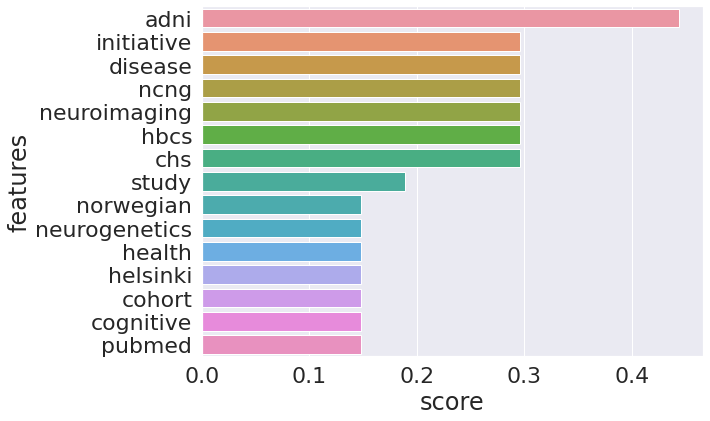

In [68]:
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

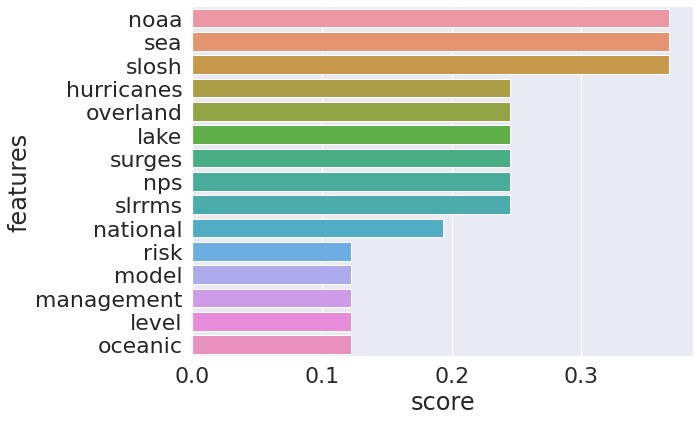

In [69]:
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

In [70]:
for i, df in enumerate(dfs):
    df.to_csv('df_'+str(i)+'.csv')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


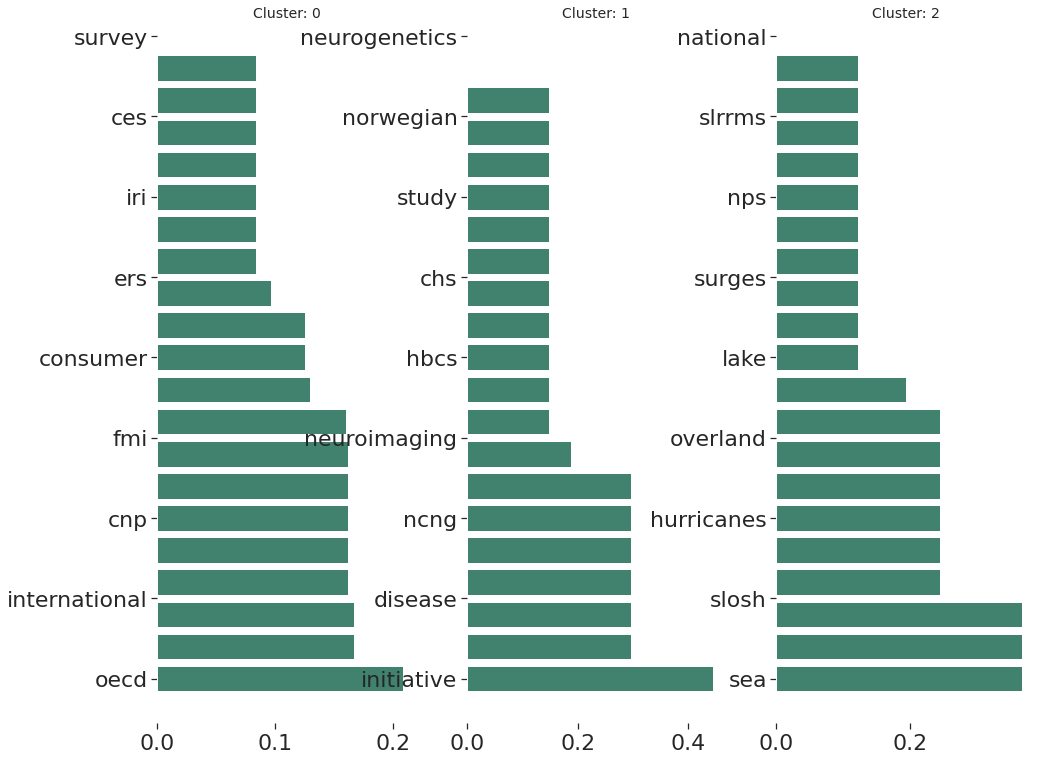

In [71]:
def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
    plt.show();
plot_features(dfs)

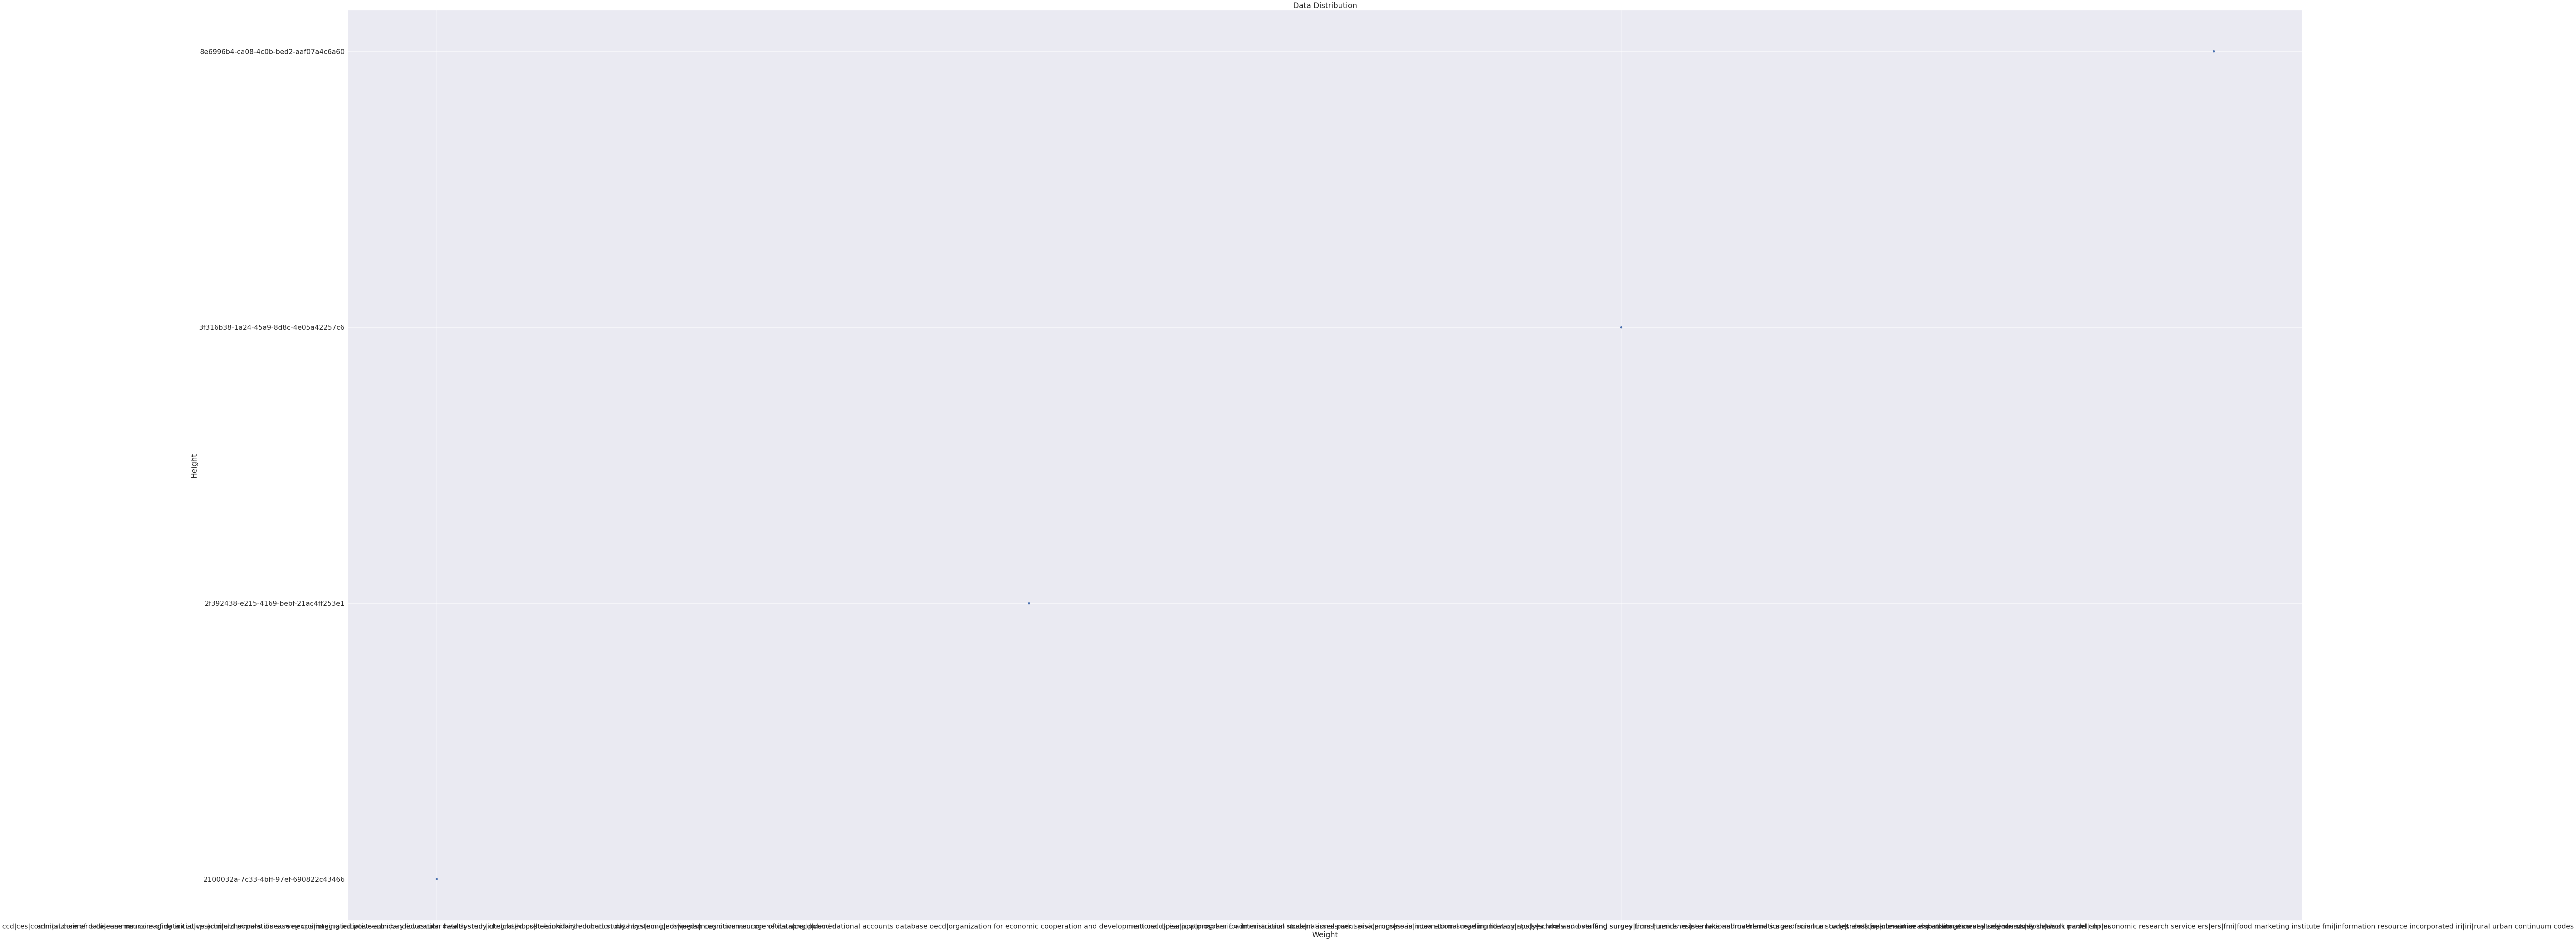

In [72]:


plt.figure(figsize=(100,50))
plt.scatter(submission['PredictionString'],submission['Id'])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Data Distribution')
plt.show()

# **# References**

[https://www.kaggle.com/code/tayyabahussain/para-data](http://)

[https://www.kaggle.com/code/tayyabahussain/coleridge-initiative-eda-modelling](http://)

<p style="color:green;font-size:20px;">Hope you like this kernel.
    </br>Please don't forget to upvote and leave your valuable comment.   
       </br> Thank you!</p><span style='font-size:100px;'>&#128513;</span></p>